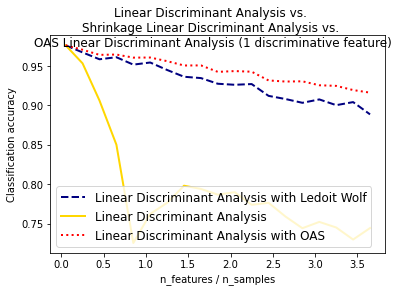

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.covariance import OAS


n_train = 20  # samples for training
n_test = 200  # samples for testing
n_averages = 50  # how often to repeat classification
n_features_max = 75  # maximum number of features
step = 4  # step size for the calculation


def generate_data(n_samples, n_features):
    """Generate random blob-ish data with noisy features.

    This returns an array of input data with shape `(n_samples, n_features)`
    and an array of `n_samples` target labels.

    Only one feature contains discriminative information, the other features
    contain only noise.
    """
    X, y = make_blobs(n_samples=n_samples, n_features=1, centers=[[-2], [2]])

    # add non-discriminative features
    if n_features > 1:
        X = np.hstack([X, np.random.randn(n_samples, n_features - 1)])
    return X, y


acc_clf1, acc_clf2, acc_clf3 = [], [], []
n_features_range = range(1, n_features_max + 1, step)
for n_features in n_features_range:
    score_clf1, score_clf2, score_clf3 = 0, 0, 0
    for _ in range(n_averages):
        X, y = generate_data(n_train, n_features)

        clf1 = LinearDiscriminantAnalysis(solver="lsqr", shrinkage="auto").fit(X, y)
        clf2 = LinearDiscriminantAnalysis(solver="lsqr", shrinkage=None).fit(X, y)
        oa = OAS(store_precision=False, assume_centered=False)
        clf3 = LinearDiscriminantAnalysis(solver="lsqr", covariance_estimator=oa).fit(
            X, y
        )

        X, y = generate_data(n_test, n_features)
        score_clf1 += clf1.score(X, y)
        score_clf2 += clf2.score(X, y)
        score_clf3 += clf3.score(X, y)

    acc_clf1.append(score_clf1 / n_averages)
    acc_clf2.append(score_clf2 / n_averages)
    acc_clf3.append(score_clf3 / n_averages)

features_samples_ratio = np.array(n_features_range) / n_train

plt.plot(
    features_samples_ratio,
    acc_clf1,
    linewidth=2,
    label="Linear Discriminant Analysis with Ledoit Wolf",
    color="navy",
    linestyle="dashed",
)
plt.plot(
    features_samples_ratio,
    acc_clf2,
    linewidth=2,
    label="Linear Discriminant Analysis",
    color="gold",
    linestyle="solid",
)
plt.plot(
    features_samples_ratio,
    acc_clf3,
    linewidth=2,
    label="Linear Discriminant Analysis with OAS",
    color="red",
    linestyle="dotted",
)

plt.xlabel("n_features / n_samples")
plt.ylabel("Classification accuracy")

plt.legend(loc=3, prop={"size": 12})
plt.suptitle(
    "Linear Discriminant Analysis vs. "
    + "\n"
    + "Shrinkage Linear Discriminant Analysis vs. "
    + "\n"
    + "OAS Linear Discriminant Analysis (1 discriminative feature)"
)
plt.show()

Fitting model on a small sub-sample of the data
done in 0.900s.
Predicting color indices on the full image (k-means)
done in 0.042s.
Predicting color indices on the full image (random)
done in 0.080s.


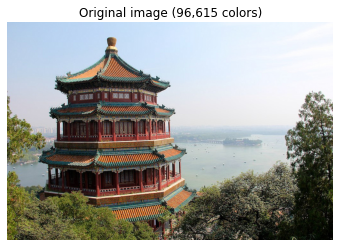

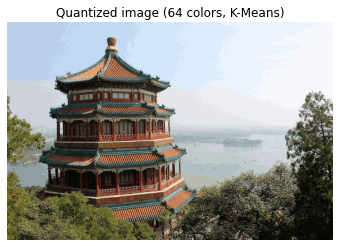

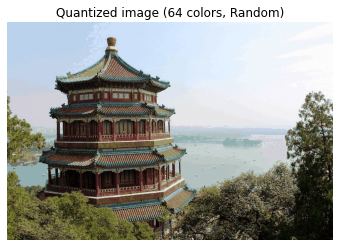

In [2]:
# Authors: Robert Layton <robertlayton@gmail.com>
#          Olivier Grisel <olivier.grisel@ensta.org>
#          Mathieu Blondel <mathieu@mblondel.org>
#
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.datasets import load_sample_image
from sklearn.utils import shuffle
from time import time

n_colors = 64

# Load the Summer Palace photo
china = load_sample_image("china.jpg")

# Convert to floats instead of the default 8 bits integer coding. Dividing by
# 255 is important so that plt.imshow behaves works well on float data (need to
# be in the range [0-1])
china = np.array(china, dtype=np.float64) / 255

# Load Image and transform to a 2D numpy array.
w, h, d = original_shape = tuple(china.shape)
assert d == 3
image_array = np.reshape(china, (w * h, d))

print("Fitting model on a small sub-sample of the data")
t0 = time()
image_array_sample = shuffle(image_array, random_state=0, n_samples=1_000)
kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array_sample)
print(f"done in {time() - t0:0.3f}s.")

# Get labels for all points
print("Predicting color indices on the full image (k-means)")
t0 = time()
labels = kmeans.predict(image_array)
print(f"done in {time() - t0:0.3f}s.")


codebook_random = shuffle(image_array, random_state=0, n_samples=n_colors)
print("Predicting color indices on the full image (random)")
t0 = time()
labels_random = pairwise_distances_argmin(codebook_random, image_array, axis=0)
print(f"done in {time() - t0:0.3f}s.")


def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    return codebook[labels].reshape(w, h, -1)


# Display all results, alongside original image
plt.figure(1)
plt.clf()
plt.axis("off")
plt.title("Original image (96,615 colors)")
plt.imshow(china)

plt.figure(2)
plt.clf()
plt.axis("off")
plt.title(f"Quantized image ({n_colors} colors, K-Means)")
plt.imshow(recreate_image(kmeans.cluster_centers_, labels, w, h))

plt.figure(3)
plt.clf()
plt.axis("off")
plt.title(f"Quantized image ({n_colors} colors, Random)")
plt.imshow(recreate_image(codebook_random, labels_random, w, h))
plt.show()

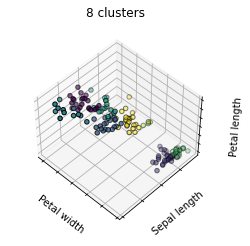

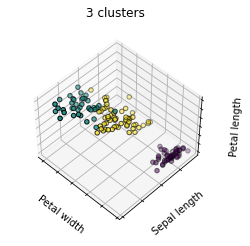

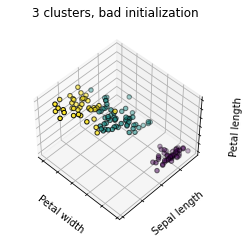

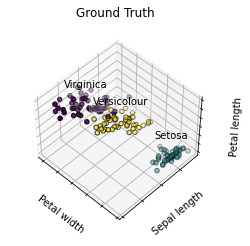

In [7]:
# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import matplotlib.pyplot as plt

# Though the following import is not directly being used, it is required
# for 3D projection to work with matplotlib < 3.2
import mpl_toolkits.mplot3d  # noqa: F401

from sklearn.cluster import KMeans
from sklearn import datasets

np.random.seed(5)

iris = datasets.load_iris()
X = iris.data
y = iris.target

estimators = [
    ("k_means_iris_8", KMeans(n_clusters=8)),
    ("k_means_iris_3", KMeans(n_clusters=3)),
    ("k_means_iris_bad_init", KMeans(n_clusters=3, n_init=1, init="random")),
]

fignum = 1
titles = ["8 clusters", "3 clusters", "3 clusters, bad initialization"]
for name, est in estimators:
    fig = plt.figure(fignum, figsize=(4, 3))
    ax = fig.add_subplot(111, projection="3d", elev=48, azim=134)
    ax.set_position([0, 0, 0.95, 1])
    est.fit(X)
    labels = est.labels_

    ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=labels.astype(float), edgecolor="k")

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_xlabel("Petal width")
    ax.set_ylabel("Sepal length")
    ax.set_zlabel("Petal length")
    ax.set_title(titles[fignum - 1])
    ax.dist = 12
    fignum = fignum + 1

# Plot the ground truth
fig = plt.figure(fignum, figsize=(4, 3))
ax = fig.add_subplot(111, projection="3d", elev=48, azim=134)
ax.set_position([0, 0, 0.95, 1])

for name, label in [("Setosa", 0), ("Versicolour", 1), ("Virginica", 2)]:
    ax.text3D(
        X[y == label, 3].mean(),
        X[y == label, 0].mean(),
        X[y == label, 2].mean() + 2,
        name,
        horizontalalignment="center",
        bbox=dict(alpha=0.2, edgecolor="w", facecolor="w"),
    )
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(float)
ax.scatter(X[:, 3], X[:, 0], X[:, 2], c=y, edgecolor="k")

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel("Petal width")
ax.set_ylabel("Sepal length")
ax.set_zlabel("Petal length")
ax.set_title("Ground Truth")
ax.dist = 12

plt.show()